Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model InceptionResNetV2, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

In [17]:
# Import

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set up

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, "test") 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "image number"
y_name = "class"

possible_labels = sorted(labels[y_name].unique())
print(possible_labels)

labels.head()

# print("Train Path:", train_path)
# print("Validation Path:", test_path)



['healthy', 'npdr', 'pdr']


,image number,class,healthy,npdr,pdr
0,1,npdr,0,1,0
1,2,npdr,0,1,0
2,3,npdr,0,1,0
3,4,npdr,0,1,0
4,5,npdr,0,1,0


In [3]:
# Custom function to convert image number to file path
extension = ".jpg"
def to_file_path(id):
    return os.path.join(labels[labels[x_name] == id][y_name].values[0], id + extension)

# Custom functions to convert image number with JPG extension
def to_jpg(id):
    return str(id) + ".jpg"

# Apply the to_file_path function if the folder is sorted by class, otherwise apply the to_jpg function
if len(os.listdir(os.path.join(train_path))) > 1 and len(os.listdir(os.path.join(test_path))) > 1:
    conversion = to_file_path
elif len(os.listdir(os.path.join(train_path))) == 0 and len(os.listdir(os.path.join(test_path))) == 0:
    conversion = to_jpg
else:
    print("Error with training and testing file sizes")
    
labels[x_name] = labels[x_name].astype(str)
labels[x_name] = labels[x_name].apply(conversion)

labels.head()


,image number,class,healthy,npdr,pdr
0,npdr/1.jpg,npdr,0,1,0
1,npdr/2.jpg,npdr,0,1,0
2,npdr/3.jpg,npdr,0,1,0
3,npdr/4.jpg,npdr,0,1,0
4,npdr/5.jpg,npdr,0,1,0


In [12]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 32
has_shuffle = True
seed = 49
image_size = (331, 331) # image height , image width

gen = ImageDataGenerator( # TODO add rotation_range=30 or zoom_range=0.4??
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = image_size, 
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = test_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = image_size,
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

Found 135 validated image filenames belonging to 3 classes.
Found 6 validated image filenames belonging to 3 classes.


(32, 3, 3, 3)

In [5]:
train_datagen = ImageDataGenerator(rescale = rescale_factor,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=has_horizontal_flip)

train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(331,331))

validation_datagen = ImageDataGenerator(rescale = rescale_factor)

validation_generator = validation_datagen.flow_from_directory(directory = train_path,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(331,331)
                                                             )

Found 168 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


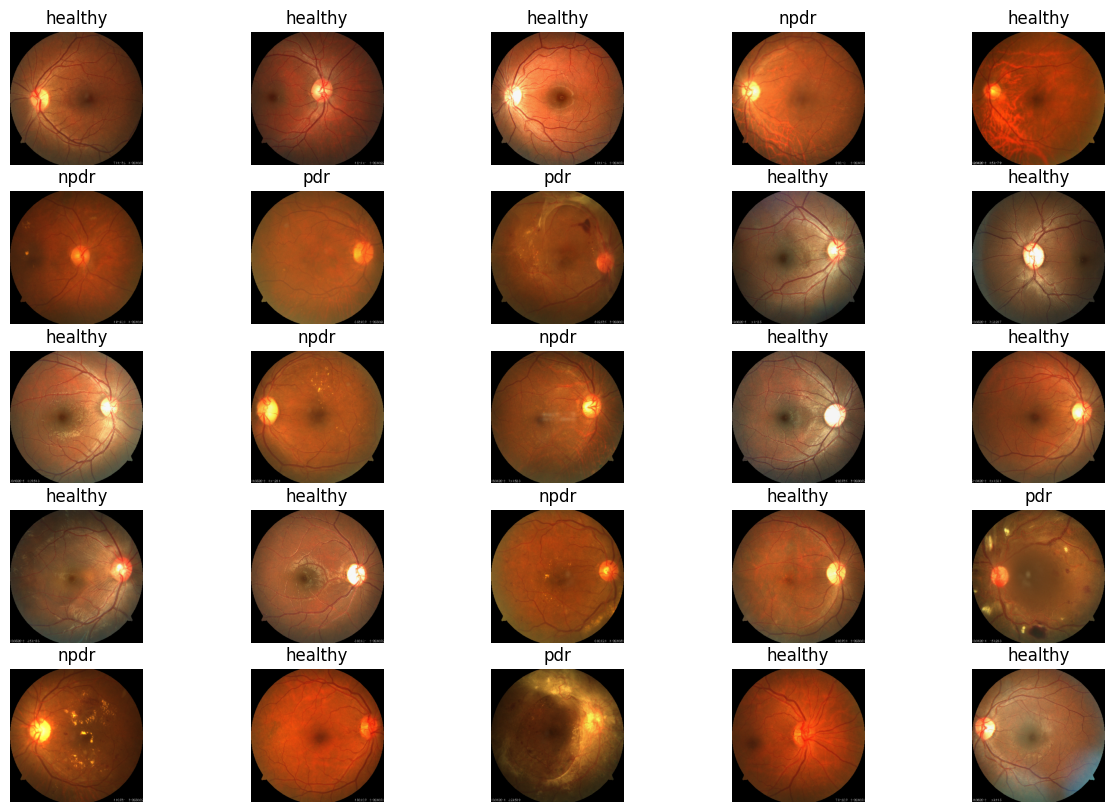

In [52]:
a = train_generator.class_indices # TODO check correct matches between labels and images
class_names = list(a.keys()) # storing class/breed names in a list


def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(25):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')

plot_images(x,y)


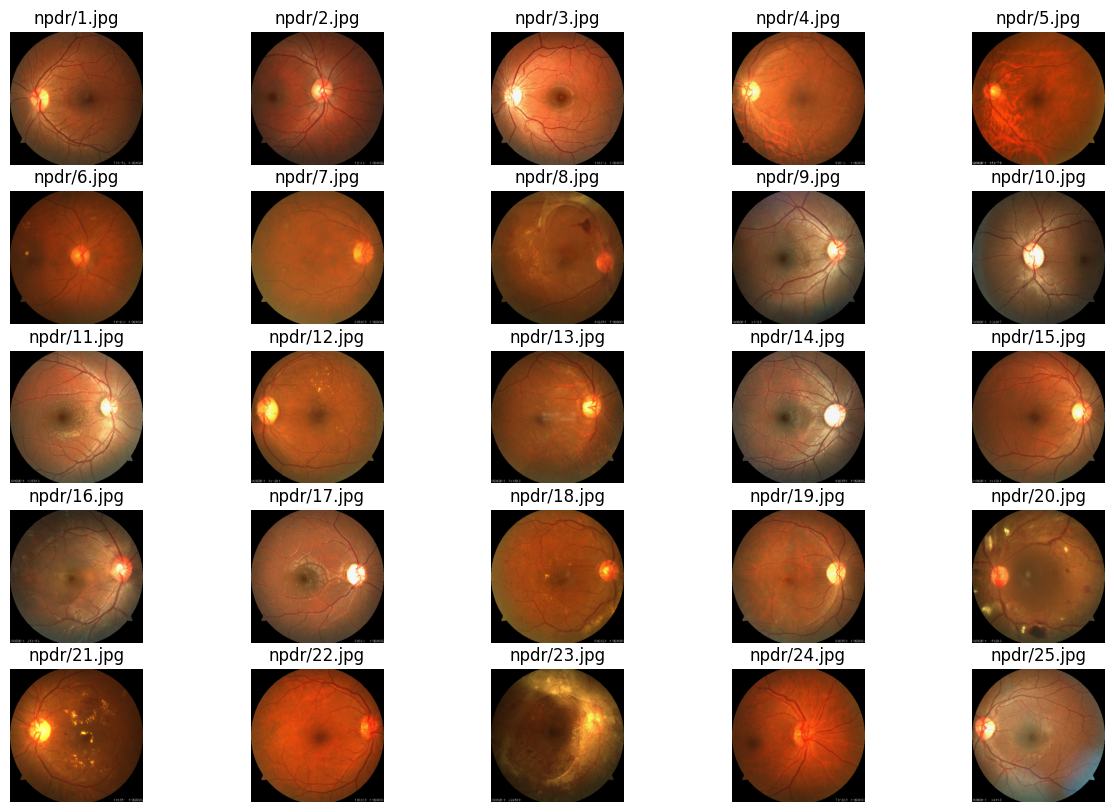

In [81]:
# Plot images

a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list


# def plot_images(img, labels):
# 	plt.figure(figsize=[15, 10])
# 	for i in range(25):
# 		plt.subplot(5, 5, i+1)
# 		plt.imshow(img[i])
# 		plt.title(class_names[np.argmax(labels[i])])
# 		plt.axis('off')

# plot_images(x,y)


def plot_images_with_numbers(img, labels, image_numbers):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(f"{image_numbers[i]}")
        plt.axis('off')

plot_images_with_numbers(x, y, labels[x_name][:25])  # Plot the first 25 images and their numbers


In [6]:
# Build model

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(3, activation='softmax')
	])

model.summary()

2023-09-14 09:32:00.217681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 09:32:00.253689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 09:32:00.253837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [20]:
# Define a function to create and compile models with different architectures
def create_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        BatchNormalization(renorm=True), #normalize the activations
        GlobalAveragePooling2D(), # reduce spatial dimensions.
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.5), # prevent overfitting.
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Experiment with different base models
base_models = {
    "EfficientNetB3": EfficientNetB3(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "ResNet50": ResNet50(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "VGG16": VGG16(input_shape=(331, 331, 3), include_top=False, weights='imagenet')
}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }

# Now you can access the results for each model and analyze their performance
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Validation Accuracy:", max(result["history"]["val_accuracy"]))
    print("Validation Loss:", min(result["history"]["val_loss"]))

Epoch 1/25
4/4 [==============================] - 8s 515ms/step - loss: nan - accuracy: 0.3495
Epoch 2/25
4/4 [==============================] - 3s 631ms/step - loss: nan - accuracy: 0.3398
Epoch 3/25
4/4 [==============================] - 3s 601ms/step - loss: nan - accuracy: 0.3883
Epoch 4/25
4/4 [==============================] - 3s 649ms/step - loss: nan - accuracy: 0.3981
Epoch 5/25
4/4 [==============================] - 3s 607ms/step - loss: nan - accuracy: 0.3592
Epoch 6/25
4/4 [==============================] - 3s 621ms/step - loss: nan - accuracy: 0.3204
Epoch 7/25
4/4 [==============================] - 3s 635ms/step - loss: nan - accuracy: 0.3010
Epoch 8/25
4/4 [==============================] - 3s 589ms/step - loss: nan - accuracy: 0.3398
Epoch 9/25
4/4 [==============================] - 3s 602ms/step - loss: nan - accuracy: 0.3689
Epoch 10/25
4/4 [==============================] - 3s 631ms/step - loss: nan - accuracy: 0.3398
Epoch 11/25
4/4 [==============================] 

KeyError: 'val_accuracy'

In [88]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = Sequential([
    base_model,
    Conv2D(16, (3, 3), activation='relu', input_shape=(331, 331, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 conv2d_2667 (Conv2D)        (None, 7, 7, 16)          221200    
                                                                 
 conv2d_2668 (Conv2D)        (None, 5, 5, 32)          4640      
                                                                 
 conv2d_2669 (Conv2D)        (None, 3, 3, 64)          18496     
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               295424    
                                                     

In [7]:
# Compile model

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [8]:
# Defining callbacks to preserve the best results

early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True,
                                        monitor='accuracy')
# early stopping call back
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [9]:
# Train model

batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=25,
					callbacks=[early])


Epoch 1/25


2023-09-14 09:35:42.749093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-14 09:35:44.311006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-14 09:35:47.681351: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1dc8ce10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-14 09:35:47.681390: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-09-14 09:35:50.951630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-14 09:36:00.121261: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

5/5 [==============================] - 46s 5s/step - loss: 1.1926 - accuracy: 0.4412 - val_loss: 0.9021 - val_accuracy: 0.5688
Epoch 2/25
5/5 [==============================] - 11s 2s/step - loss: 1.2067 - accuracy: 0.5882 - val_loss: 0.7826 - val_accuracy: 0.6313
Epoch 3/25
5/5 [==============================] - 11s 3s/step - loss: 0.9902 - accuracy: 0.5515 - val_loss: 0.7565 - val_accuracy: 0.6562
Epoch 4/25
5/5 [==============================] - 11s 3s/step - loss: 0.8865 - accuracy: 0.6544 - val_loss: 0.6986 - val_accuracy: 0.7625
Epoch 5/25
5/5 [==============================] - 11s 2s/step - loss: 0.7699 - accuracy: 0.6471 - val_loss: 0.5826 - val_accuracy: 0.8000
Epoch 6/25
5/5 [==============================] - 10s 3s/step - loss: 0.7372 - accuracy: 0.7279 - val_loss: 0.5781 - val_accuracy: 0.7750
Epoch 7/25
5/5 [==============================] - 11s 2s/step - loss: 0.7215 - accuracy: 0.6985 - val_loss: 0.5186 - val_accuracy: 0.8250
Epoch 8/25
5/5 [=============================

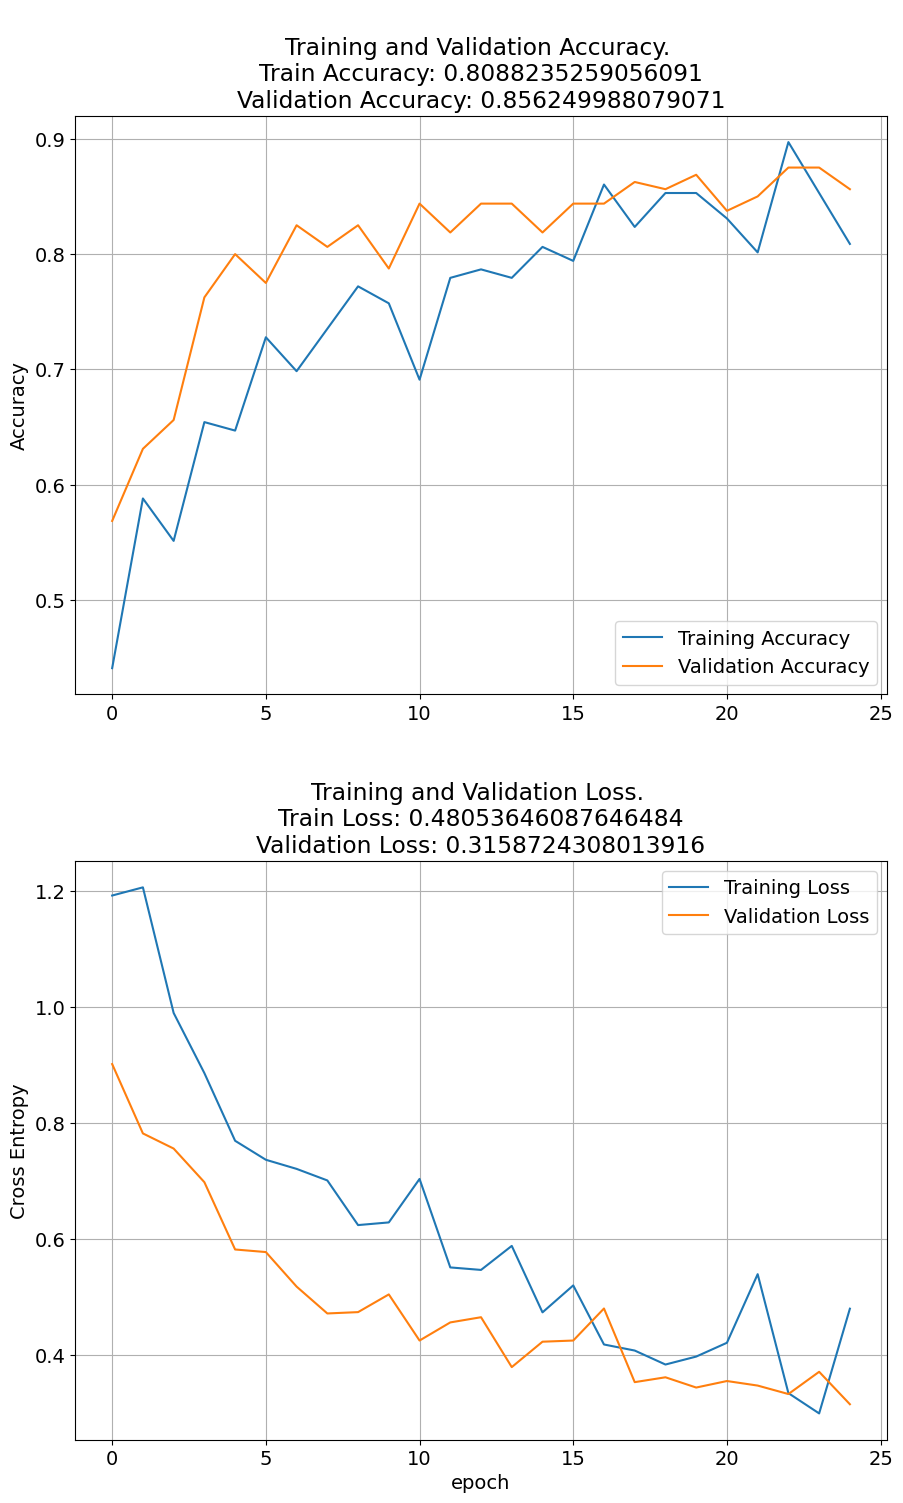

In [10]:
# Visualize model

# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] # or maybe val_acc
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [11]:
# Evaluate model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


6/6 [==============================] - 6s 926ms/step - loss: 0.3063 - accuracy: 0.8631
[0.3062507212162018, 0.863095223903656]
Accuracy: 86.3095%
Loss:  0.3062507212162018


1/1 [==============================] - 0s 19ms/step
Prediction: [[0.45068353 0.5243837  0.02493278]]
Labels: ['healthy', 'npdr', 'pdr']
Predicted class: npdr


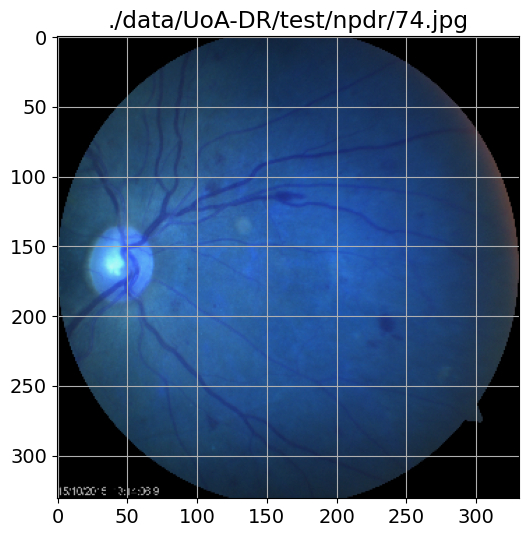

In [111]:
# Testing

test_img_path = os.path.join(test_path, "npdr/74.jpg")
# test_img_path="PDR.jpg"
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
 
plt.figure(figsize=(6,6))
plt.title(test_img_path)
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print("Prediction:", prediction)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

print("Labels:", possible_labels) # TODO check if this is matched properly
print("Predicted class:", possible_labels[predicted_class_index])



In [112]:
# Save model

model.save("models/Model.h5")
